In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
import numpy as np
import matplotlib.pyplot as plt 

from collections import Counter

from PIL import Image


In [25]:
import torch
from torch import nn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# Load the CSV file into a pandas DataFrame
# file from https://weilab.math.msu.edu/DataLibrary/2D/
df = pd.read_csv('bace.csv')

In [4]:
for f in df["mol"]:
    print (f)

O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C
Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(=O)C)(CC(C)C)C1=O)CCc1ccccc1)[C@H](O)[C@@H]1[NH2+]C[C@H](OCCC)C1
S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(OC)ccc1)Cc1ccccc1)C
S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c(N)c(F)c2)[C@H](O)[C@@H]([NH2+]Cc2cc(ccc2)C(C)(C)C)C1
S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(F)(F)F)Cc1ccccc1)C
S1(=O)C[C@@H](Cc2cc(OC(C(F)(F)F)C(F)(F)F)c(N)c(F)c2)[C@H](O)[C@@H]([NH2+]Cc2cc(ccc2)C(C)(C)C)C1
S(=O)(=O)(CCCCC)C[C@@H](NC(=O)c1cccnc1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)CC)Cc1cc(F)cc(F)c1
Fc1c2c(ccc1)[C@@]([NH+]=C2N)(C=1C=C(C)C(=O)N(C=1)CC)c1cc(ccc1)-c1cc(cnc1)C#CC
O1c2c(cc(cc2)CC)[C@@H]([NH2+]C[C@@H](O)[C@H]2NC(=O)C=3C=CC(=O)N(CCCCc4cc(C2)ccc4)C=3)CC12CCC2
O=C1N(CCCC1)C(C)(C)[C@@H]1C[C@@H](CCC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(C)C)Cc1ccccc1
Fc1cc(cc(F)c1)C[C@H](NC(=O)c1cc(cc(c1)C)C(=O)N(CCC)CCC)[C@H](O)[C@@H]1[NH2+]C[C@H](Oc2ccc

In [4]:

# Convert each SMILES string into an RDKit molecule
molecules = [Chem.MolFromSmiles(smiles) for smiles in df['mol']]

# Atomic formulas
formulas = [rdMolDescriptors.CalcMolFormula(m) for m in molecules]

In [232]:
# convert images to arrays. 
def mol_to_image_array (mol, size=(224,224)):
    img = Draw.MolToImage(mol, size=size)
    
    img = img.convert("L")

    img_array = np.array(img).reshape(1, size[0], size[0])

    return img_array


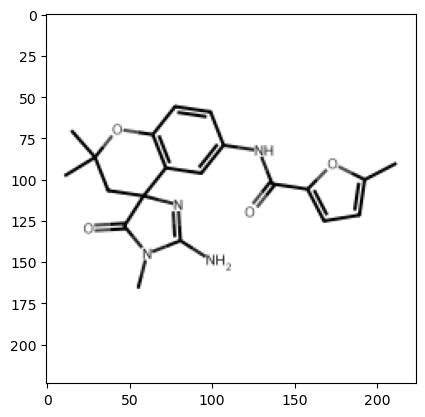

In [233]:
test = mol_to_image_array(molecules[900])
plt.imshow(test[0], cmap="gray")

In [234]:
image_arrays = [mol_to_image_array(mol) for mol in molecules]

In [235]:
# convert molecules into an array representation
# index in array = atomic number
# value = number of atoms
# index 0 is the total number of atoms in that molecule. 

atomic_counts = []

for i,m in enumerate(molecules):
    atomic_count = np.zeros(108)
    for atom in Chem.AddHs(m).GetAtoms():
        atomic_count[atom.GetAtomicNum()] += 1
    atomic_counts.append(atomic_count)
    atomic_counts[i][0] = sum(atomic_counts[i][:])


atomic_counts = np.array(atomic_counts)
atomic_counts.shape

(1513, 108)

In [350]:
test_max = np.array([np.max(x.nonzero()) for x in atomic_counts])
test_all = [x.nonzero() for x in atomic_counts]
test_all = [np.ndarray.tolist(x[0]) for x in test_all]
test_all = np.array([x for xs in test_all for x in xs])

np.unique(test_all)

# H=1, C=6, N=7, O=8, F=9, S=16, CL=17, Br=35, I=53
# limit labels to only these 9 elements. 
# Convert `atomic_counts` array from dim=108 to dim=10 


array([ 0,  1,  6,  7,  8,  9, 16, 17, 35, 53])

In [351]:
def atomCountConversion(atom_count_array):
    temp = np.zeros(10)
    temp[0] = atom_count_array[0]
    temp[1] = atom_count_array[1]
    temp[2] = atom_count_array[6]
    temp[3] = atom_count_array[7]
    temp[4] = atom_count_array[8]
    temp[5] = atom_count_array[9]
    temp[6] = atom_count_array[16]
    temp[7] = atom_count_array[17]
    temp[8] = atom_count_array[35]
    temp[9] = atom_count_array[53]
    return temp 

In [360]:
atomCountConversion(atomic_counts[592])

array([91., 47., 33.,  5.,  4.,  2.,  0.,  0.,  0.,  0.])

In [236]:
# convert iamges to tensors

image_arrays = np.array(image_arrays)
image_tensors = torch.tensor(image_arrays) / 255.0

image_tensors.shape

torch.Size([1513, 1, 224, 224])

In [237]:
# scale atomic counts in the range of 0->1
#   use logp1 scaling (invertible by np.expm1)
# convert to tensors 

# atomic_counts_scaled = np.array([np.log1p(x) for x in atomic_counts])

# try without scaling 
atomic_counts_scaled = np.array(atomic_counts)

atomic_counts_tensor = torch.tensor(atomic_counts_scaled).float() 

In [63]:
np.log1p(atomic_counts[0]), np.expm1(atomic_counts_scaled[0])


(array([4.18965474, 3.52636052, 0.        , 0.        , 0.        ,
        0.        , 3.33220451, 1.38629436, 1.09861229, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [238]:
train_x, test_x, train_y, test_y = train_test_split(image_tensors, atomic_counts_tensor, test_size=0.2)

train_x.dtype, train_y.dtype, test_x.dtype, test_y.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

In [239]:
# build the model 
# Try linear + ReLU model first
# Then CNN of that doesn't work 

class chemModel_V1(nn.Module):
    def __init__(self,
                 input_shape: int, 
                 hidden_units:int, 
                 output_shape:int):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, hidden_units), 
            nn.Linear(hidden_units, hidden_units), 
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer1(x)
    
model1 = chemModel_V1(50176, 10, 108)

In [240]:
# create dataset types from tensors
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

# create dataloaders 

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=32)


In [241]:
trainFeaturesBatch, trainLabelsBatch  = (next(iter(train_dl)))
trainFeaturesBatch.shape

torch.Size([32, 1, 224, 224])

In [242]:
flattenModel = nn.Flatten()

x = trainFeaturesBatch[0]
## x.shape
flattenModel(x).shape

torch.Size([1, 50176])

In [152]:
# accuracy 
def accuracy_fn(y_pred, y_true):
    correct = ((y_pred - y_true)).sum().item()
    acc = (correct / y_pred.sum().item()) * 100
    return acc 



In [243]:
train_losses = []
test_losses = []

In [244]:
# train the model

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.001)

epochs = 1001

for epoch in range(epochs):
    # print(f"Epoch: {epoch}")
    training_loss = 0
    training_acc = 0

    # loop through batches 
    for batch, (x, y) in enumerate (train_dl):

        model1.train()

        y_logits = model1(x)

        loss = loss_fn(y_logits, y)

        training_loss += loss.item()
        training_acc += accuracy_fn(y_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 1 == 0:
            # print(f"Passed through: {batch * len(x)} / {len(train_dl.dataset)} samples, loss: {loss:.4f}, acc: {training_acc:.4f}")

    # compute train_loss per batch

    training_loss = training_loss / len(train_dl)
    train_losses.append(training_loss)

    # testing loop 

    test_loss = 0
    test_acc = 0 

    model1.eval()

    with torch.inference_mode():
        for x_test, y_test in test_dl:
            test_logits = model1(x_test)

            test_loss += loss_fn(test_logits, y_test)

            test_acc += accuracy_fn(y_test, test_logits)

    # test loss per batch
    test_loss = test_loss / len(test_dl)
    test_losses.append(test_loss)
    test_acc = test_acc / len(test_dl)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Train Loss: {training_loss:.4f} Test Loss: {test_loss:.4f}")

Epoch: 0, Train Loss: 55.0374 Test Loss: 32.5004
Epoch: 100, Train Loss: 3.6382 Test Loss: 4.5847
Epoch: 200, Train Loss: 3.7476 Test Loss: 3.8518
Epoch: 300, Train Loss: 2.1986 Test Loss: 6.7615
Epoch: 400, Train Loss: 2.5932 Test Loss: 3.6183
Epoch: 500, Train Loss: 1.8081 Test Loss: 4.1056
Epoch: 600, Train Loss: 1.2740 Test Loss: 3.5578
Epoch: 700, Train Loss: 1.7808 Test Loss: 5.8879
Epoch: 800, Train Loss: 1.6574 Test Loss: 5.9650
Epoch: 900, Train Loss: 0.9235 Test Loss: 4.6430
Epoch: 1000, Train Loss: 1.0815 Test Loss: 3.9755


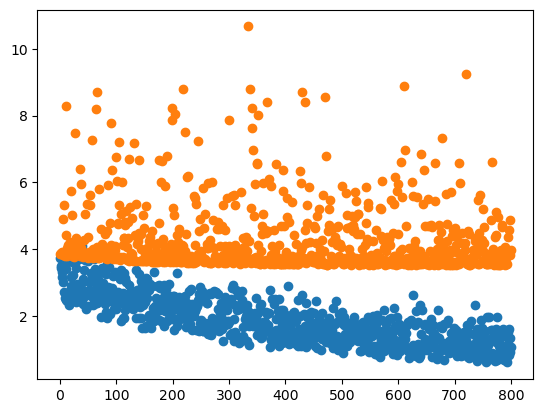

In [248]:
plt.scatter(range(len(train_losses[200:])), train_losses[200:])
plt.scatter(range(len(test_losses[200:])), test_losses[200:])

In [251]:
model1.eval()
testFeaturesBatch, testLabelsBatch  = (next(iter(test_dl)))
molecule_true = (testLabelsBatch[12])
with torch.inference_mode():
    molecule_predicted = (model1(testFeaturesBatch[12]).squeeze())
    molecule_predicted[molecule_predicted < 0] = 0
    molecule_predicted_raw = model1(testFeaturesBatch[12]).squeeze()
    molecule_predicted_raw[molecule_predicted_raw < 0] = 0 


In [252]:
molecule_true, np.floor(molecule_predicted)

(tensor([48., 19.,  0.,  0.,  0.,  0., 22.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 tensor([52., 24.,  0.,  0.,  0.,  0., 21.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [255]:
# Try second model with non-linear functions. 

class chemModel_V2(nn.Module):
    def __init__(self,
                 input_shape: int, 
                 hidden_units:int, 
                 output_shape:int):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, hidden_units), 
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer1(x)
    
model2 = chemModel_V2(50176, 10, 108)

In [256]:
train_losses = []
test_losses = []



In [257]:
# train the model

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.001)

epochs = 1001

for epoch in range(epochs):
    # print(f"Epoch: {epoch}")
    training_loss = 0
    training_acc = 0

    # loop through batches 
    for batch, (x, y) in enumerate (train_dl):

        model2.train()

        y_logits = model2(x)

        loss = loss_fn(y_logits, y)
        
        training_loss += loss 
        training_acc += accuracy_fn(y_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 1 == 0:
            # print(f"Passed through: {batch * len(x)} / {len(train_dl.dataset)} samples, loss: {loss:.4f}, acc: {training_acc:.4f}")

    # compute train_loss per batch

    training_loss = training_loss / len(train_dl)
    train_losses.append(training_loss.item())

    # testing loop 

    test_loss = 0
    test_acc = 0 

    model2.eval()

    with torch.inference_mode():
        for x_test, y_test in test_dl:
            test_logits = model2(x_test)

            test_loss += loss_fn(test_logits, y_test)

            test_acc += accuracy_fn(y_test, test_logits)

    # test loss per batch
    test_loss = test_loss / len(test_dl)
    test_losses.append(test_loss.item())
    test_acc = test_acc / len(test_dl)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Train Loss: {training_loss:.4f} Test Loss: {test_loss:.4f}")

Epoch: 0, Train Loss: 52.8872 Test Loss: 45.2117
Epoch: 100, Train Loss: 4.1472 Test Loss: 5.1846
Epoch: 200, Train Loss: 3.5996 Test Loss: 5.4391
Epoch: 300, Train Loss: 2.5209 Test Loss: 3.7562
Epoch: 400, Train Loss: 2.3398 Test Loss: 4.2135
Epoch: 500, Train Loss: 2.0547 Test Loss: 3.8529
Epoch: 600, Train Loss: 1.7808 Test Loss: 3.7685
Epoch: 700, Train Loss: 1.6515 Test Loss: 5.7450
Epoch: 800, Train Loss: 1.6463 Test Loss: 4.5661
Epoch: 900, Train Loss: 1.1774 Test Loss: 3.5724
Epoch: 1000, Train Loss: 0.9896 Test Loss: 5.5316


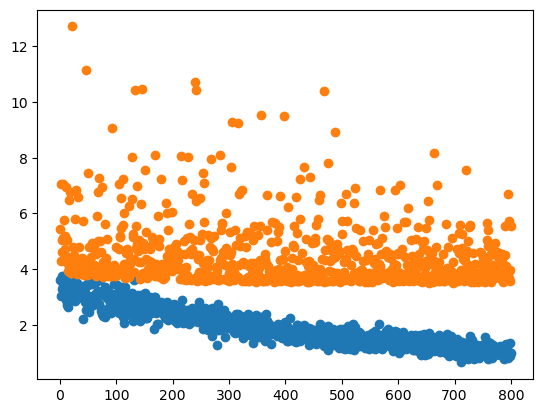

In [258]:
plt.scatter(range(len(train_losses[200:])), train_losses[200:])
plt.scatter(range(len(test_losses[200:])), test_losses[200:])

In [261]:
model2.eval()
testFeaturesBatch, testLabelsBatch  = (next(iter(test_dl)))
molecule_true = testLabelsBatch[12]
with torch.inference_mode():
    molecule_predicted = model2(testFeaturesBatch[12]).squeeze()
    molecule_predicted[molecule_predicted < 0] = 0
    molecule_predicted_raw = model2(testFeaturesBatch[12]).squeeze()
    molecule_predicted_raw[molecule_predicted_raw < 0] = 0 


In [263]:
testLabelsBatch[12], np.round(molecule_predicted)

(tensor([48., 19.,  0.,  0.,  0.,  0., 22.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 tensor([58., 28.,  0.,  0.,  0.,  0., 23.,  3.,  3.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [282]:
# CNN network 

class CNNChemicalModel_V1(nn.Module):
    """ Tiny VGG network"""
    def __init__(self, 
                 input_shape: int, 
                 hidden_units:int, 
                 output_shape:int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0), ## 222
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0), ## 220
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ### 110
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                      kernel_size=3, padding=0), ## 108
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                      kernel_size=3, padding=0), ## 106
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  ## 53
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_units*53*53, out_features=hidden_units*53*53),
            nn.Linear(in_features=hidden_units*53*53, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.conv_block_1(x)
        z = self.conv_block_2(z)
        # print(z.shape)
        z = self.classifier(z)
        return z
    
model3 = CNNChemicalModel_V1(1, 5, 108)

In [283]:
train_losses = []
test_losses = []


In [289]:
# train the model

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model3.parameters(), lr=0.001)

epochs = 11

for epoch in range(epochs):
    # print(f"Epoch: {epoch}")
    training_loss = 0
    training_acc = 0

    # loop through batches 
    for batch, (x, y) in enumerate (train_dl):

        model3.train()

        y_logits = model3(x)

        loss = loss_fn(y_logits, y)
        
        training_loss += loss 
        training_acc += accuracy_fn(y_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 1 == 0:
            # print(f"Passed through: {batch * len(x)} / {len(train_dl.dataset)} samples, loss: {loss:.4f}, acc: {training_acc:.4f}")

    # compute train_loss per batch

    training_loss = training_loss / len(train_dl)
    train_losses.append(training_loss.item())

    # testing loop 

    test_loss = 0
    test_acc = 0 

    model3.eval()

    with torch.inference_mode():
        for x_test, y_test in test_dl:
            test_logits = model3(x_test)

            test_loss += loss_fn(test_logits, y_test)

            test_acc += accuracy_fn(y_test, test_logits)

    # test loss per batch
    test_loss = test_loss / len(test_dl)
    test_losses.append(test_loss.item())
    test_acc = test_acc / len(test_dl)
    if epoch % 1 == 0:
        print(f"Epoch: {epoch}, Train Loss: {training_loss:.4f} Test Loss: {test_loss:.4f}")

Epoch: 0, Train Loss: 1.3815 Test Loss: 1.9332
Epoch: 1, Train Loss: 0.4335 Test Loss: 1.8422
Epoch: 2, Train Loss: 0.3495 Test Loss: 1.8398
Epoch: 3, Train Loss: 0.3295 Test Loss: 1.8164
Epoch: 4, Train Loss: 0.3270 Test Loss: 1.8378
Epoch: 5, Train Loss: 0.3244 Test Loss: 1.8439
Epoch: 6, Train Loss: 0.3291 Test Loss: 1.7986
Epoch: 7, Train Loss: 0.3363 Test Loss: 1.8176
Epoch: 8, Train Loss: 0.3450 Test Loss: 1.8086
Epoch: 9, Train Loss: 0.3363 Test Loss: 1.8045
Epoch: 10, Train Loss: 0.3317 Test Loss: 1.7966


In [306]:
model3.eval()
testFeaturesBatch, testLabelsBatch  = (next(iter(test_dl)))
molecule_true = testLabelsBatch[1]
with torch.inference_mode():
    molecule_predicted = model3(testFeaturesBatch[1].unsqueeze(dim=0)).squeeze()
    # molecule_predicted[molecule_predicted < 0] = 0


In [307]:
molecule_true, molecule_predicted

(tensor([84., 41.,  0.,  0.,  0.,  0., 30.,  5.,  8.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 tensor([79.2464, 40.1904,  0.0000,  0.0000,  0.0000,  0.0000, 29.6483,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,

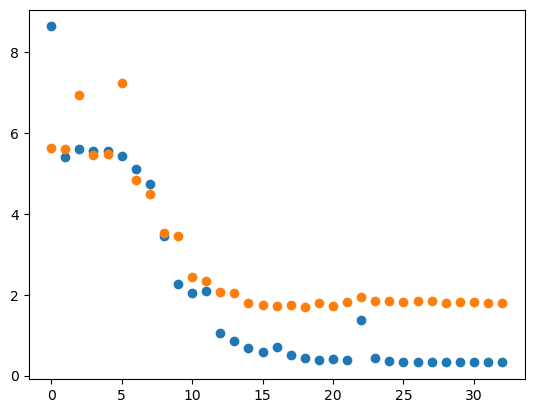

In [290]:
plt.scatter(range(len(train_losses[0:])), train_losses[0:])
plt.scatter(range(len(test_losses[0:])), test_losses[0:])

In [303]:
# CNN network 

class CNNChemicalModel_V2(nn.Module):
    """ Tiny VGG network"""
    def __init__(self, 
                 input_shape: int, 
                 hidden_units:int, 
                 output_shape:int):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0), ## 222
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=2*hidden_units,
                      kernel_size=3, stride=1, padding=0), ## 220
            nn.BatchNorm2d(2*hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=2*hidden_units, out_channels=3*hidden_units, 
                      kernel_size=3, padding=0), ## 218
            nn.BatchNorm2d(3*hidden_units),
            nn.ReLU(),
            # global pool
            nn.AdaptiveAvgPool2d(1)
        )


        self.fullyConnected = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_units*3, out_features=hidden_units*3),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*3, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.conv_block(x)
        #print(z.shape)
        z = self.fullyConnected(z)
        return z
    
model4 = CNNChemicalModel_V2(1, 10, 108)

torch.Size([32, 30, 1, 1])


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1370],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1376],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1397],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1480],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1500],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1462]],
       grad_fn=<ReluBackward0>)

In [305]:
# train the model

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model4.parameters(), lr=0.001)

epochs = 11

for epoch in range(epochs):
    # print(f"Epoch: {epoch}")
    training_loss = 0
    training_acc = 0

    # loop through batches 
    for batch, (x, y) in enumerate (train_dl):

        model4.train()

        y_logits = model4(x)

        loss = loss_fn(y_logits, y)
        
        training_loss += loss 
        training_acc += accuracy_fn(y_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 1 == 0:
            # print(f"Passed through: {batch * len(x)} / {len(train_dl.dataset)} samples, loss: {loss:.4f}, acc: {training_acc:.4f}")

    # compute train_loss per batch

    training_loss = training_loss / len(train_dl)
    train_losses.append(training_loss.item())

    # testing loop 

    test_loss = 0
    test_acc = 0 

    model4.eval()

    with torch.inference_mode():
        for x_test, y_test in test_dl:
            test_logits = model4(x_test)

            test_loss += loss_fn(test_logits, y_test)

            test_acc += accuracy_fn(y_test, test_logits)

    # test loss per batch
    test_loss = test_loss / len(test_dl)
    test_losses.append(test_loss.item())
    test_acc = test_acc / len(test_dl)
    if epoch % 1 == 0:
        print(f"Epoch: {epoch}, Train Loss: {training_loss:.4f} Test Loss: {test_loss:.4f}")

Epoch: 0, Train Loss: 43.0875 Test Loss: 155.3428
Epoch: 1, Train Loss: 42.9943 Test Loss: 243.2666
Epoch: 2, Train Loss: 42.9553 Test Loss: 233.7064
Epoch: 3, Train Loss: 42.8838 Test Loss: 776.9426
Epoch: 4, Train Loss: 42.9615 Test Loss: 967.4178
Epoch: 5, Train Loss: 42.8272 Test Loss: 136.7932
Epoch: 6, Train Loss: 42.8919 Test Loss: 44.4327
Epoch: 7, Train Loss: 42.8190 Test Loss: 90.0392
Epoch: 8, Train Loss: 42.8589 Test Loss: 877.9819
Epoch: 9, Train Loss: 42.8499 Test Loss: 1398.0833
Epoch: 10, Train Loss: 42.8495 Test Loss: 44.1281
